## 数据格式转化脚本

#### 将voc目标检测数据转换为.rec格式，方便MXNet读取

In [1]:
import os
import sys
import random
import xml.etree.ElementTree as ET

REC_NAME = './REC_Data/voc2012'
IMAGE_PATH = './VOC2012/JPEGImages'
ANNOTATION_PATH = './VOC2012/Annotations'
VOC_LABELS = {
    'aeroplane': (1, 'Vehicle'),
    'bicycle': (2, 'Vehicle'),
    'bird': (3, 'Animal'),
    'boat': (4, 'Vehicle'),
    'bottle': (5, 'Indoor'),
    'bus': (6, 'Vehicle'),
    'car': (7, 'Vehicle'),
    'cat': (8, 'Animal'),
    'chair': (9, 'Indoor'),
    'cow': (10, 'Animal'),
    'diningtable': (11, 'Indoor'),
    'dog': (12, 'Animal'),
    'horse': (13, 'Animal'),
    'motorbike': (14, 'Vehicle'),
    'person': (15, 'Person'),
    'pottedplant': (16, 'Indoor'),
    'sheep': (17, 'Animal'),
    'sofa': (18, 'Indoor'),
    'train': (19, 'Vehicle'),
    'tvmonitor': (20, 'Indoor'),
}

if not os.path.exists(os.path.split(REC_NAME)[0]):
    os.makedirs(os.path.split(REC_NAME)[0])
if not os.path.exists(IMAGE_PATH):
    raise BaseException('file {} is not exists'.format(IMAGE_PATH))
file_names = sorted(os.listdir(IMAGE_PATH))
random.seed = 10
random.shuffle(file_names)
sys.stdout.write('Number of images is {}'.format(len(file_names)))

Number of images is 17125

In [2]:
def xml_parse(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    # Image shape.
    size = root.find('size')
    shape = [int(size.find('height').text),
             int(size.find('width').text),
             int(size.find('depth').text)]
    # Find annotations.
    bboxes = []
    labels = []
    labels_text = []
    difficult = []
    truncated = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(VOC_LABELS[label][0])
 
        if obj.find('difficult'):
            difficult.append(int(obj.find('difficult').text))
        else:
            difficult.append(0)
        if obj.find('truncated'):
            truncated.append(int(obj.find('truncated').text))
        else:
            truncated.append(0)
        bbox = obj.find('bndbox')
        # mxnet data format xmin,ymin,xmax,ymax
        bboxes.append((
                        float(bbox.find('xmin').text) / shape[1],
                        float(bbox.find('ymin').text) / shape[0],   
                        float(bbox.find('xmax').text) / shape[1],
                        float(bbox.find('ymax').text) / shape[0],
                       ))
    return shape, bboxes, labels, labels_text, difficult, truncated

items = []
for i in range(len(file_names)):
    item = ['{}\t2\t5'.format(i),]
    xml_file = os.path.join(ANNOTATION_PATH, 
                            file_names[i].strip('.jpg') + '.xml')
    _, box, label, _, _, _ = xml_parse(xml_file)
    for obj in zip(box, label):
        item.append(str(obj[-1]))
        _ = [item.append(str(coord)) for coord in obj[0]]
    item.append(file_names[i])
    items.append('\t'.join(item) + '\n')
with open(REC_NAME + '.lst', 'w') as f:
    for line in items:
        f.write(line)
sys.stdout.write("'.lst' file generare completed")

'.lst' file generare completed

In [4]:
import subprocess
import mxnet as mx
 
im2rec_path = os.path.join(mx.__path__[0], 'tools/im2rec.py')  # 寻找im2rec.py路径
if not os.path.exists(im2rec_path):
    im2rec_path = os.path.join(os.path.dirname(os.path.dirname(mx.__path__[0])), 'tools/im2rec.py')
sys.stdout.write("File 'im2rec.py' in path '{}'".format(im2rec_path))
subprocess.check_call(["python", '/usr/local/lib/python2.7/dist-packages/mxnet/tools/im2rec.py',
        os.path.abspath('{}.lst'.format(REC_NAME)), os.path.abspath(IMAGE_PATH), "--pack-label"])

File 'im2rec.py' in path '/usr/local/lib/python3.5/dist-packages/mxnet/tools/im2rec.py'

0

In [5]:
import mxnet as mx

rec = mx.image.ImageDetIter(
            path_imgrec     = './REC_Data/voc2012.rec',
            path_imglist    = '',
            batch_size      = 4,
            data_shape      = (3, 512, 512))
batch_data = rec.next()
batch_data.data[0][2].shape, batch_data.label[0][2].shape

/usr/local/lib/python3.5/dist-packages/mxnet/recordio.py:370: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  header = header._replace(label=np.fromstring(s, np.float32, header.flag))


((3, 512, 512), (56, 5))

1


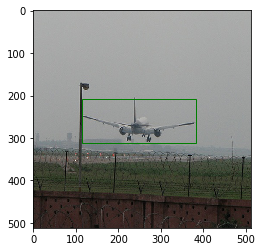

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# .asnumpy比使用np.array速度快得多
plt.imshow(batch_data.data[0][3].asnumpy().transpose(1,2,0)/255.)

currentAxis=plt.gca()
for i in range(6):
    box = batch_data.label[0][3][i][1:].asnumpy()*512
    if any(box<0):
        continue
    print(int(batch_data.label[0][3][i][0].asscalar()))
    rect=patches.Rectangle((box[0], box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='g',facecolor='none')
    currentAxis.add_patch(rect)

plt.show()